In [1]:
# Import modules 
import sys
from os import getcwd
from os.path import dirname
path = dirname(dirname(getcwd()))
sys.path.append(path)

from MintPy.interpret_toolkit import InterpretToolkit
from MintPy.utils import combine_top_features, save_pickle, load_pickle, merge_dict, merge_nested_dict
import pandas as pd
import numpy as np
import pickle
from joblib import load

In [2]:
#
# LOADING THE MODEL OBJECTS AND THEIR TRAINING EXAMPLES 
#
# Define target feature
TARGET_COLUMN = 'cat_rt'

# Load the model objects. In this case, we are using 3 
# popular models availabe in scikit-learn 
model_fname = ['RandomForest.pkl', 'LogisticRegression.pkl', 'GradientBoostingClassifier.pkl']
model_objs = [load(fname) for fname in model_fname]

# Load the training dataset 
data  = pd.read_csv('example_data.csv')
targets = data[TARGET_COLUMN].values

# only want to use these columns below
cols_to_use = ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_cloud',
            'lat_hf', 'low_cloud', 'mid_cloud', 'sat_irbt', 'sens_hf',
            'sfcT_hrs_ab_frez', 'sfcT_hrs_bl_frez', 'sfc_rough', 'sfc_temp',
            'swave_flux','temp2m', 'tmp2m_hrs_ab_frez', 'tmp2m_hrs_bl_frez',
            'tot_cloud', 'uplwav_flux','vbd_flux', 'vdd_flux','wind10m',
            'date_marker', 'urban','rural','d_ground','d_rad_d','d_rad_u',
            'hrrr_dT']

units = ['W m$^{-2}$', '$^\circ$C', 'm s$^{-1}$', 'W m$^{-2}$', '%', 'W m$^{-2}$', '%', '%', 
         '$^\circ$C', 'W m$^{-2}$', 'hrs', 'hrs', 'unitless','$^\circ$C', 'W m$^{-2}$', '$^\circ$C', 
         'hrs', 'hrs', '%', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', 'm s$^{-1}$', 'days', 'unitless', 
         'unitless', 'W m$^{-2}$', 'W m$^{-2}$', 'W m$^{-2}$', '$^\circ$C']

pretty_names = [r'$\lambda_{\downarrow}$', '$T_{d}$', '$V_{fric}$', 'Gflux', '$Cloud_{high}$',
 '$Lat_{F}$', '$Cloud_{low}$', '$Cloud_{mid}$', 'IRBT', '$Sens_{F}$',
 'Hours $T_{sfc}$ $> $0', 'Hours $T_{sfc}$ $<= $0', 'SfcRough', '$T_{sfc}$',
 '$I_{S}$', '$T_{2m}$', 'Hours $T_{2m}$ $> $0', 'Hours $T_{2m}$ $<= $0',
 '$Cloud_{Tot}$', r'$\lambda_{\uparrow}$', 'VBD', 'VDD', '10m wind',
 'Date marker', 'Urban', 'Rural', 'Diff1', 'Diff2', 'Diff3',
 '$T_{sfc}$ - $T_{2m}$']

feature_units = {c : u for c,u in zip(cols_to_use, units)}
readable_feature_names = {c : u for c,u in zip(cols_to_use, pretty_names)}

# get predictor subset of dataframe (only the predictors used in training the model)
examples = data[cols_to_use]

/Users/Home/.conda/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Home/.conda/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Load the results 
fnames = [f'{model_name.replace(".pkl","")}_perm_imp_results.pkl' for model_name in model_fname]
results = load_pickle(fnames)
print(results)

# Initialize an empty class
myInterpreter = InterpretToolkit() 
myInterpreter.set_results(results, option='permutation_importance')

{'GradientBoostingClassifier': <MintPy.PermutationImportance.result.ImportanceResult object at 0x11e2d5438>, 'LogisticRegression': <MintPy.PermutationImportance.result.ImportanceResult object at 0x107692ef0>, 'RandomForestClassifier': <MintPy.PermutationImportance.result.ImportanceResult object at 0x11e2c6f60>}


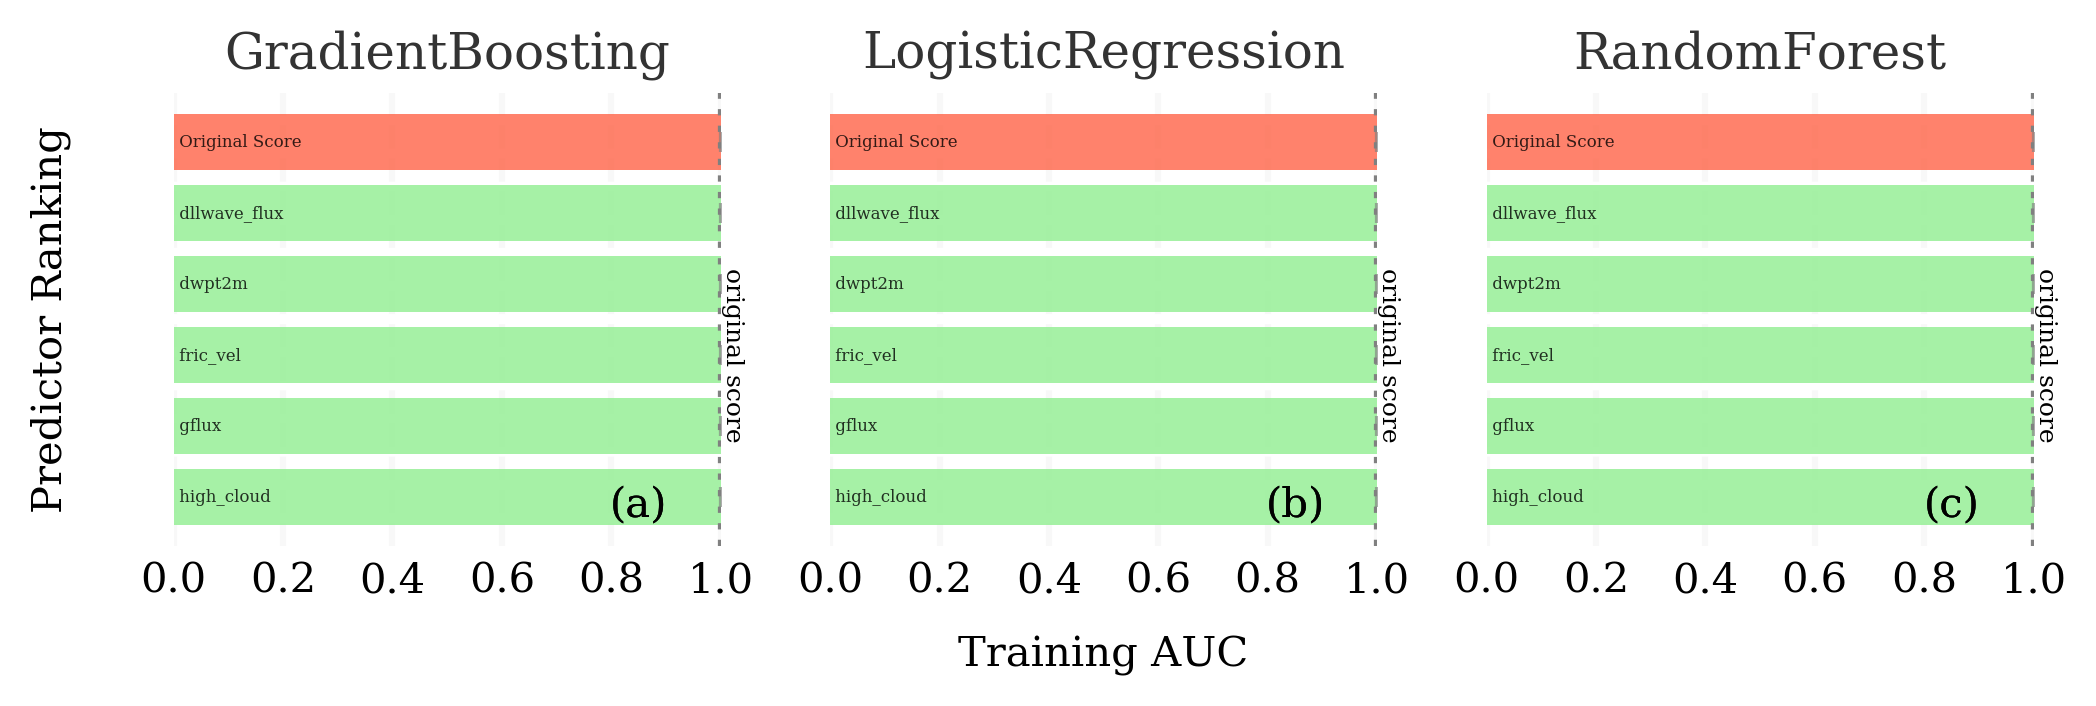

In [4]:
fig = myInterpreter.plot_importance(multipass=True, 
                              metric = "Training AUC",
                              num_vars_to_plot=5)

In [5]:
# There is a built-in method to return a list of the top features for each model
important_vars = myInterpreter.get_important_vars(results, multipass=True)
print(important_vars)
important_vars = combine_top_features(important_vars, nvars=5)
print(important_vars)

{'GradientBoostingClassifier': ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_cloud'], 'LogisticRegression': ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_cloud'], 'RandomForestClassifier': ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_cloud']}
['dllwave_flux', 'fric_vel', 'gflux', 'high_cloud', 'dwpt2m']


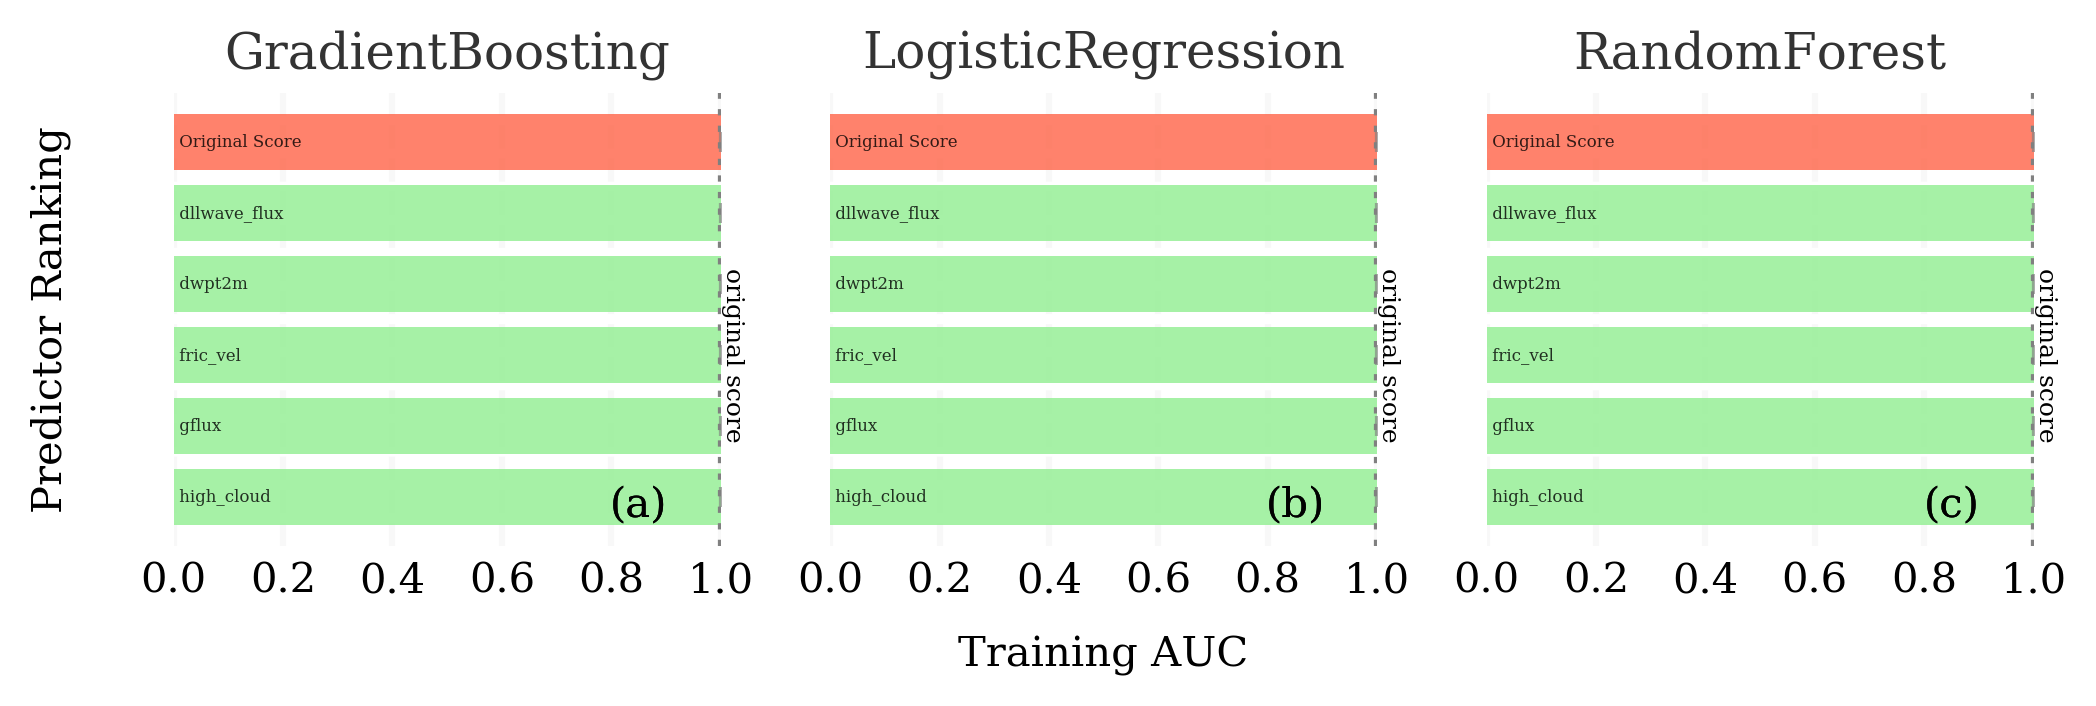

In [6]:
fig = myInterpreter.plot_importance(multipass=True, 
                              metric = "Training AUC",
                              num_vars_to_plot=5)

# Fix the axis labelling for cases with only one panel!!!

# Partial Dependence Plots

Once we known what features are important, we explore their functional relationship with the target variable. MintPy has a built-in function to take the important features from multiple model turn it into a single list with any duplicate features removed. 

Using 3 processors...
Using 3 processors...
Using 3 processors...


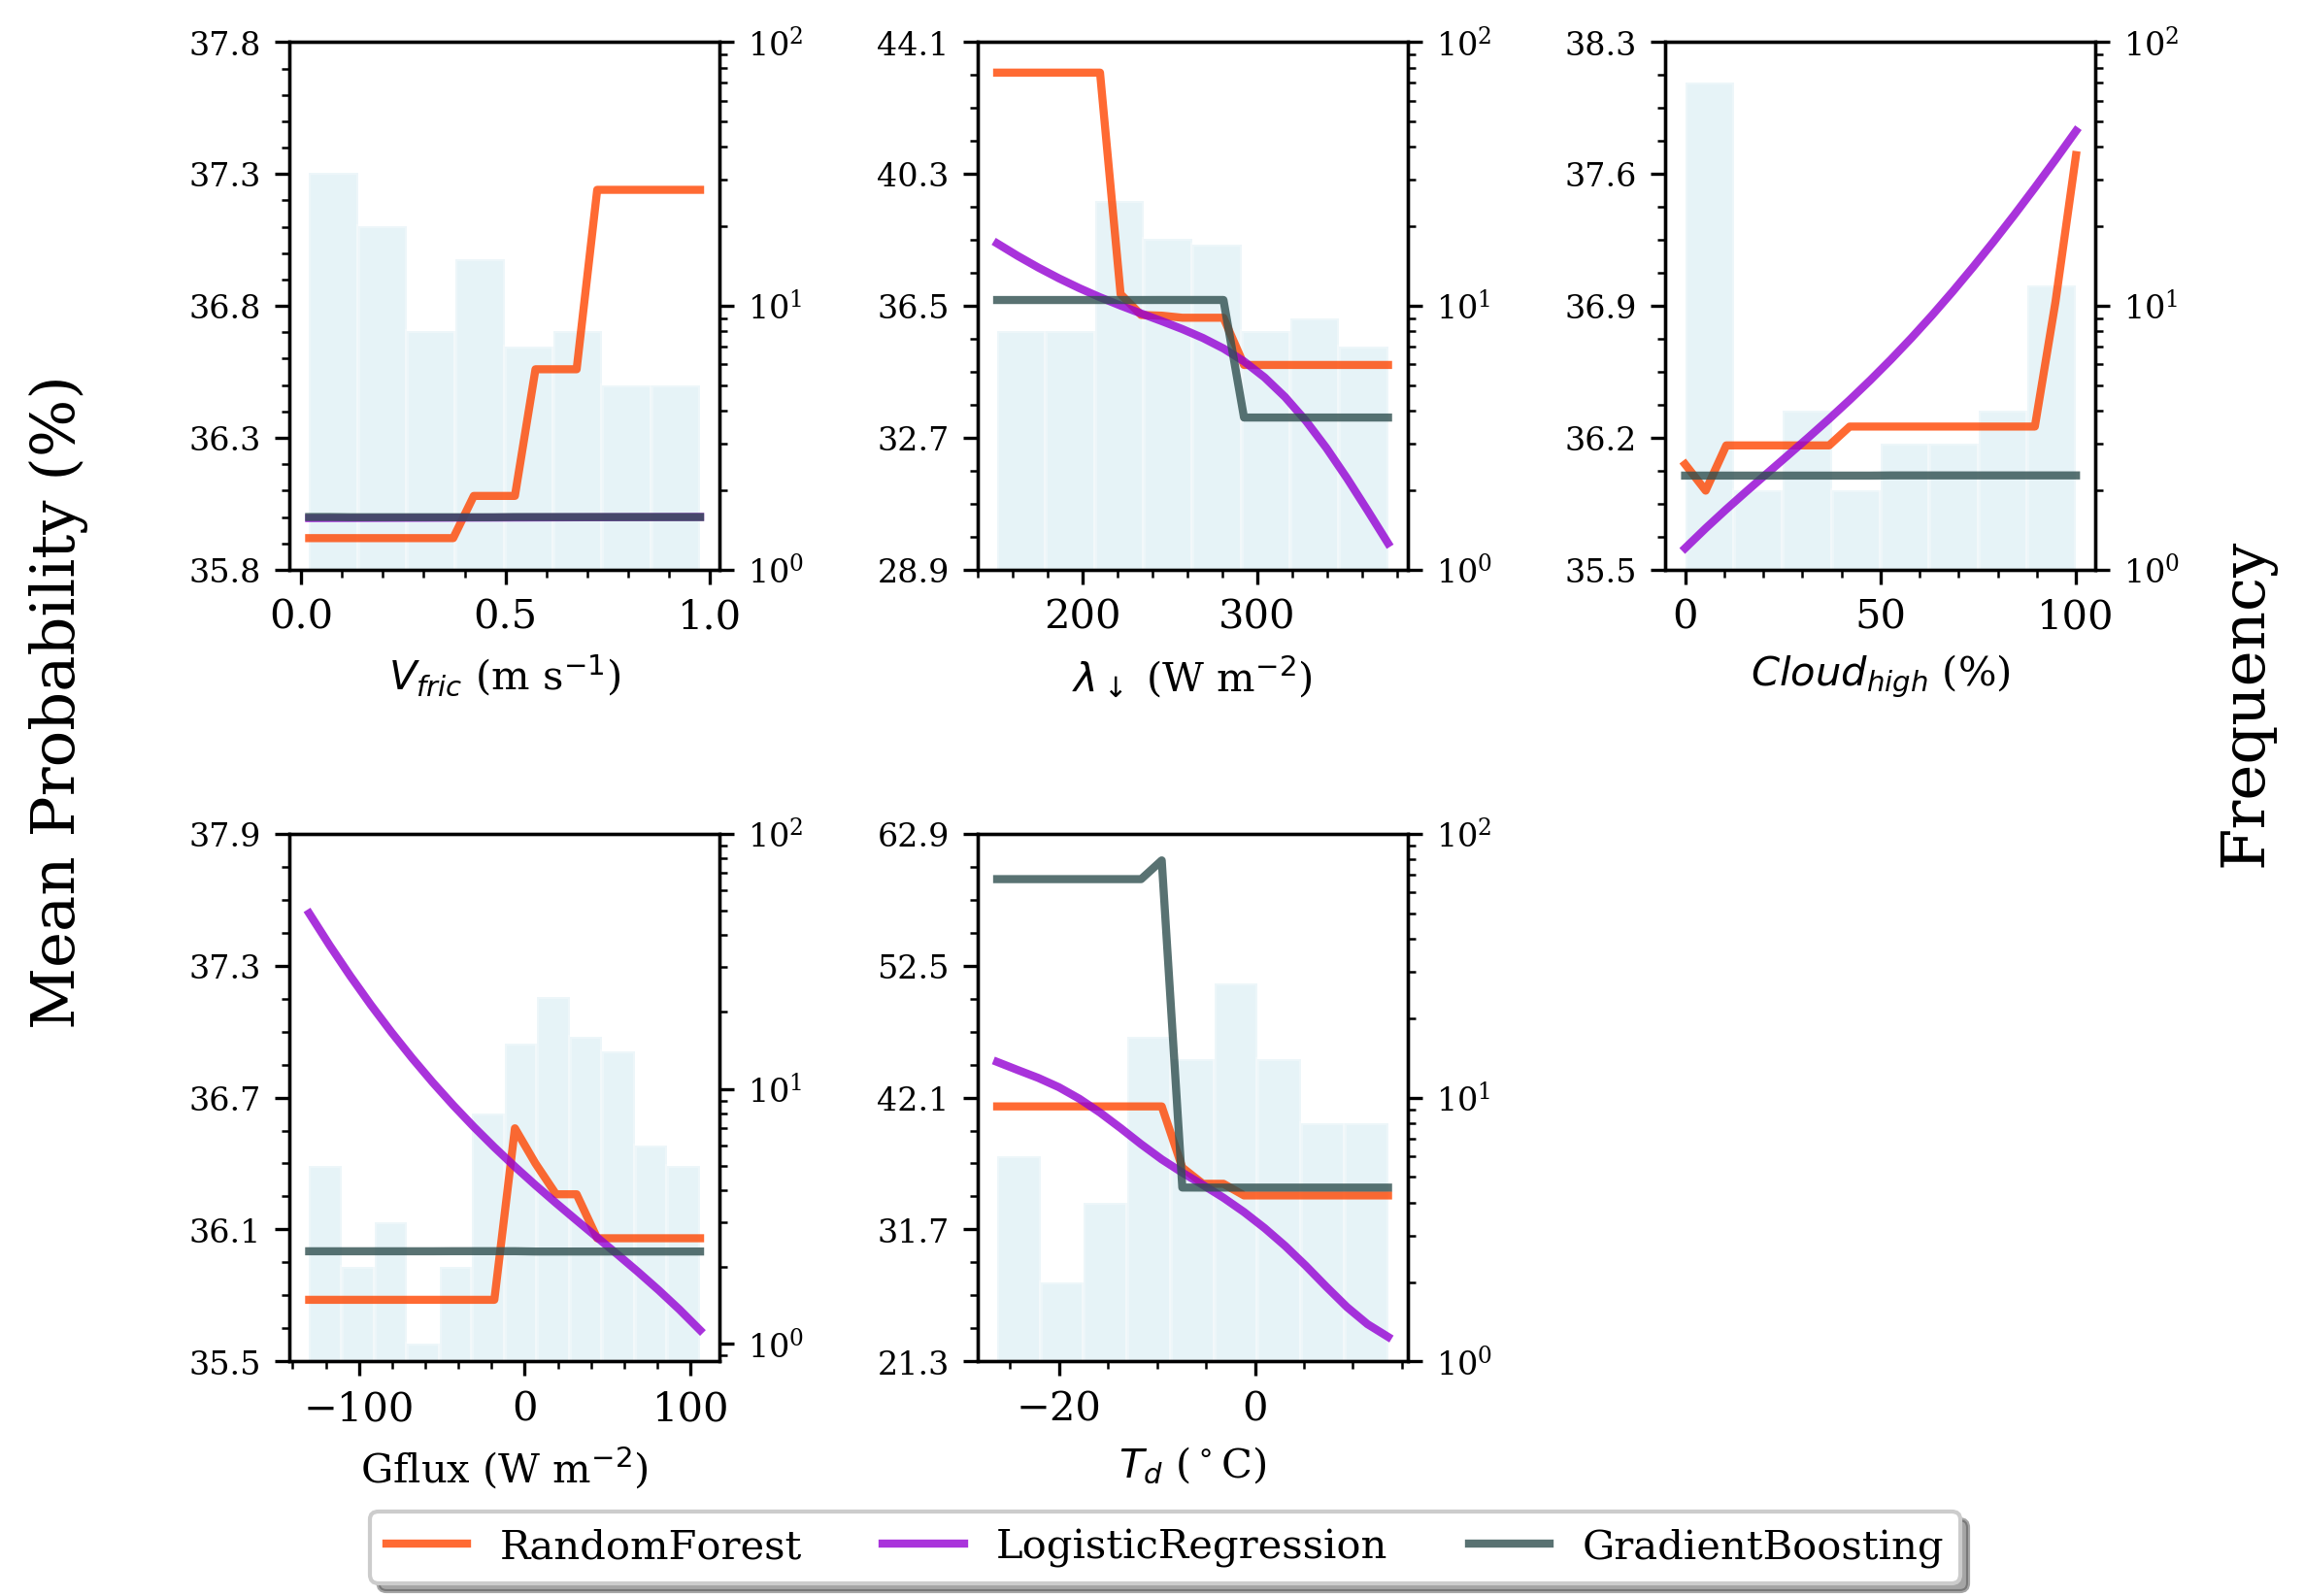

In [7]:
pdp_results=[]
for model, model_name in zip(model_objs, model_fname): 
    print('============================')
    myInterpreter = InterpretToolkit(model=model, 
                             examples=examples, 
                             targets=targets,
                                )
    result_dict = myInterpreter.run_pd(features=important_vars, 
                                  nbootstrap=1, subsample=1.0, njobs=3)
    pdp_results.append(result_dict)
       
pdp_results = merge_nested_dict(pdp_results)

myInterpreter.set_results(pdp_results, option='pdp')
fig, axes = myInterpreter.plot_pd(feature_units=feature_units,
                                 readable_feature_names=readable_feature_names)
# Add some functionality to generate automatically generate user-friendly left y ticks marks

# Accumulated Local Effect

Models for ALE: ['RandomForestClassifier']
Using 3 processors...
Models for ALE: ['LogisticRegression']
Using 3 processors...
Models for ALE: ['GradientBoostingClassifier']
Using 3 processors...


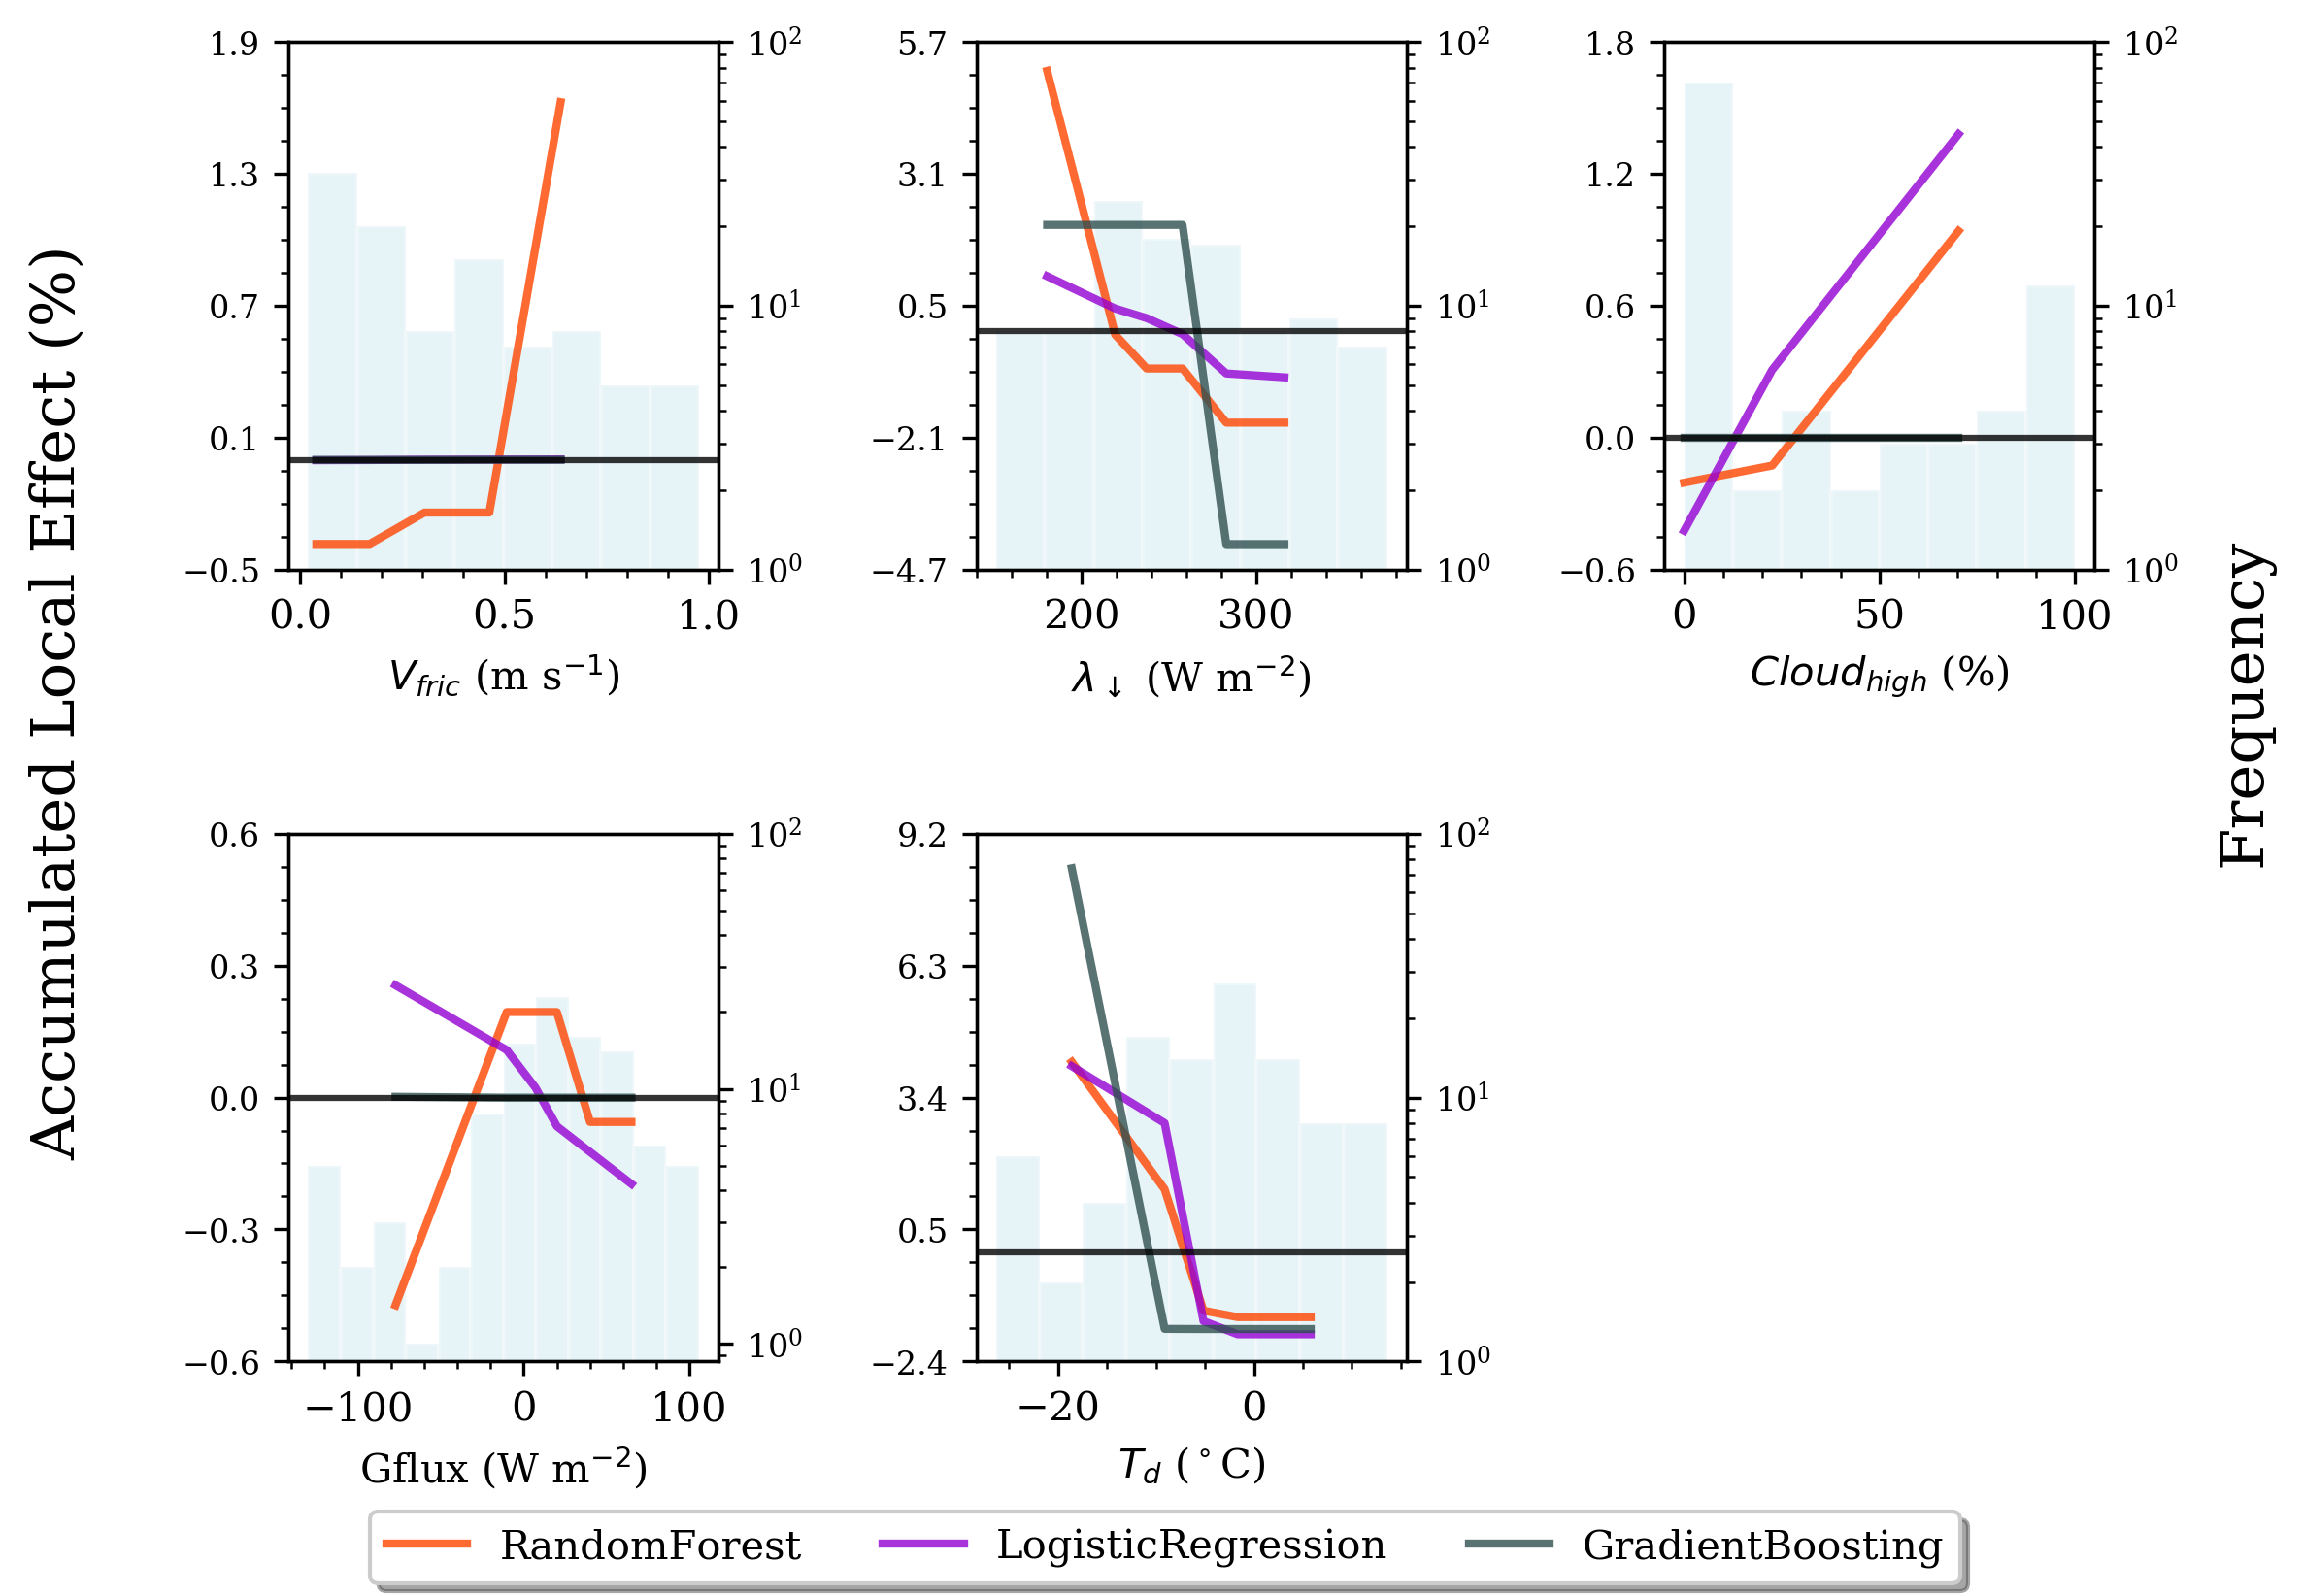

In [8]:
ale_results=[]
for model, model_name in zip(model_objs, model_fname): 
    myInterpreter = InterpretToolkit(model=model, 
                             examples=examples, 
                             targets=targets,
                                )
    result_dict = myInterpreter.run_ale(features=important_vars, 
                                  nbootstrap=1, subsample=1.0, njobs=3)
    ale_results.append(result_dict)
       
ale_results = merge_nested_dict(ale_results)
myInterpreter.set_results(ale_results, option='ale')
fig, axes = myInterpreter.plot_ale(feature_units=feature_units,
                                 readable_feature_names=readable_feature_names)

# Feature Contributions (Random Forest Only)

For random forest, it is possible to breakdown a prediction into a series of contributions from the predictors. 

In [9]:
out_dict = myInterpreter.run_tree_interpreter(performance_based=True, n_examples=5)

GradientBoostingClassifier is not accepted for this method. Passing...


In [10]:
fig = myInterpreter.plot_tree_interpreter(readable_feature_names=readable_feature_names)

UnboundLocalError: local variable 'fig' referenced before assignment

# Second-order PDP and ALE 

In [ ]:
feature_tuple = [('dllwave_flux', 'fric_vel'), ('dwpt2m', 'fric_vel'), ('gflux', 'high_cloud')]
myInterpreter.run_pd(features=feature_tuple, nbootstrap=1, subsample=1.0, njobs=3)
fig, axes = myInterpreter.plot_pd(feature_units=feature_units,
                                readable_feature_names=readable_feature_names)

In [ ]:
feature_tuple = [('dllwave_flux', 'dwpt2m'),('dwpt2m', 'fric_vel'), ('gflux', 'high_cloud')]
myInterpreter.run_ale(features=feature_tuple, nbootstrap=1, subsample=1.0, njobs=3)
fig, axes = myInterpreter.plot_ale(feature_units=feature_units,
                                 readable_feature_names=readable_feature_names)